In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence

# 1. Image and JSON Pre-processing

# Change JSON categories and convert extensions from jpg to png

In [ ]:


# Updated category mapping to include "difficult"
category_mapping = {
    "red blood cell": "uninfected",
    "leukocyte": "uninfected",
    "gametocyte": "infected",
    "ring": "infected",
    "trophozoite": "infected",
    "schizont": "infected",
    "difficult": "infected"  # "difficult" as infected
}

def update_json_file(json_file_path, output_file_path):
    with open(json_file_path, 'r') as f:
        data = json.load(f)
# This allow to change the image path name and the same time change the category mapping to the new one
    for entry in data:

        old_pathname = entry["image"]["pathname"]
        if old_pathname.endswith(".jpg"):
            new_pathname = old_pathname.replace(".jpg", ".png")
            entry["image"]["pathname"] = new_pathname
        for obj in entry["objects"]:
            old_category = obj["category"]
            obj["category"] = category_mapping.get(old_category, "infected")


    with open(output_file_path, 'w') as f:
        json.dump(data, f, indent=4)

    print(f"Updated JSON saved to: {output_file_path}")


training_json_path = "/content/drive/MyDrive/Vision_project/training.json"
test_json_path = "/content/drive/MyDrive/Vision_project/test.json"


updated_training_json_path = "/content/drive/MyDrive/Vision_project/UNET_segmentation/training_updated.json"
updated_test_json_path = "/content/drive/MyDrive/Vision_project/UNET_segmentation/test_updated.json"

# Update the JSON files
update_json_file(training_json_path, updated_training_json_path)
update_json_file(test_json_path, updated_test_json_path)


Updated JSON saved to: /content/drive/MyDrive/Vision_project/UNET_segmentation/training_updated.json
Updated JSON saved to: /content/drive/MyDrive/Vision_project/UNET_segmentation/test_updated.json


In [ ]:
import json

def verify_categories_and_get_stats(json_file_path, is_training=True):

    total_cells = 0
    infected_count = 0
    uninfected_count = 0
    invalid_categories = set()
    image_count = 0

    with open(json_file_path, 'r') as f:
        data = json.load(f)

    for entry in data:
        image_count += 1
        for obj in entry["objects"]:
            category = obj["category"]
            total_cells += 1
            if category == "infected":
                infected_count += 1
            elif category == "uninfected":
                uninfected_count += 1
            else:
                invalid_categories.add(category)

    print(f"Statistics for file: {json_file_path}")
    print(f"Total images: {image_count}")
    print(f"Total cells: {total_cells}")
    print(f"Infected cells: {infected_count}")
    print(f"Uninfected cells: {uninfected_count}")

    if invalid_categories:
        print(f"Invalid categories found: {invalid_categories}")
    else:
        print("All categories are valid ('infected' and 'uninfected').")

    return image_count

updated_training_json_path = '/content/drive/MyDrive/Vision_project/UNET_segmentation/training_updated.json'
updated_test_json_path = '/content/drive/MyDrive/Vision_project/UNET_segmentation/test_updated.json'

# Verify and get stats
training_image_count = verify_categories_and_get_stats(updated_training_json_path, is_training=True)
test_image_count = verify_categories_and_get_stats(updated_test_json_path, is_training=False)

total_images = training_image_count + test_image_count
print("\nSummary:")
print(f"Total training images: {training_image_count}")
print(f"Total test images: {test_image_count}")
print(f"Total images: {total_images}")


Statistics for file: /content/drive/MyDrive/Vision_project/UNET_segmentation/training_updated.json
Total images: 1208
Total cells: 80113
Infected cells: 2590
Uninfected cells: 77523
All categories are valid ('infected' and 'uninfected').
Statistics for file: /content/drive/MyDrive/Vision_project/UNET_segmentation/test_updated.json
Total images: 120
Total cells: 5922
Infected cells: 308
Uninfected cells: 5614
All categories are valid ('infected' and 'uninfected').

Summary:
Total training images: 1208
Total test images: 120
Total images: 1328


# Paths to avoid confusion

In [ ]:
images_path="/content/drive/MyDrive/Vision_project/images"
training_json = '/content/drive/MyDrive/Vision_project/UNET_segmentation/training_updated.json'
test_json = '/content/drive/MyDrive/Vision_project/UNET_segmentation/test_updated.json'

# Verify images dimensions

In [ ]:
import os
from PIL import Image

def check_image_dimensions(images_path):

    dimension_counts = {}
    image_files = [f for f in os.listdir(images_path) if f.lower().endswith(('.jpg', '.png'))]

    for image_file in image_files:
        image_path = os.path.join(images_path, image_file)

        try:
            with Image.open(image_path) as img:
                dimensions = img.size  # (width, height)
                if dimensions not in dimension_counts:
                    dimension_counts[dimensions] = 0
                dimension_counts[dimensions] += 1
        except Exception as e:
            print(f"Error reading image {image_file}: {e}")

    print(f"Checked {len(image_files)} images in {images_path}.")
    for dim, count in dimension_counts.items():
        print(f"Dimension {dim}: {count} images")

    return dimension_counts

dimensions_summary = check_image_dimensions(images_path)


Checked 1328 images in /content/drive/MyDrive/Vision_project/images.
Dimension (1600, 1200): 1208 images
Dimension (1944, 1383): 120 images


# Creating mask for classification

In [ ]:
import json
import os
from PIL import Image, ImageDraw

import os
import json
from PIL import Image, ImageDraw

from PIL import Image, ImageDraw
import os
import json

def create_masks_with_matched_sizes(json_file, images_path, masks_output_dir):

    os.makedirs(masks_output_dir, exist_ok=True)

    with open(json_file, 'r') as f:
        data = json.load(f)

    for entry in data:
        # Get the image filename and path
        image_filename = os.path.basename(entry['image']['pathname'])
        image_path = os.path.join(images_path, image_filename)
        try:
            with Image.open(image_path) as img:
                image_size = img.size
        except FileNotFoundError:
            print(f"Warning: Image {image_filename} not found, skipping...")
            continue

        mask = Image.new("L", image_size, 0)

        # Draw bounding boxes on the mask
        draw = ImageDraw.Draw(mask)
        for obj in entry['objects']:
            bbox = obj['bounding_box']
            category = obj['category']

            if category == "uninfected":
                value = 50
            elif category == "infected":
                value = 200
            else:
                continue

            # Draw the bounding box
            top_left = (bbox['minimum']['c'], bbox['minimum']['r'])
            bottom_right = (bbox['maximum']['c'], bbox['maximum']['r'])
            draw.rectangle([top_left, bottom_right], fill=value)


        mask_filename = image_filename.replace('.png', '_mask.png')
        mask_path = os.path.join(masks_output_dir, mask_filename)
        mask.save(mask_path, format="PNG")

    print(f"Masks successfully created and saved in {masks_output_dir}.")



training_masks_output_dir = '/content/drive/MyDrive/Vision_project/UNET_segmentation/training_masks'
test_masks_output_dir = '/content/drive/MyDrive/Vision_project/UNET_segmentation/test_masks'

# Create masks for training and test sets
create_masks_with_matched_sizes(training_json, images_path, training_masks_output_dir)
create_masks_with_matched_sizes(test_json, images_path, test_masks_output_dir)


Masks successfully created and saved in /content/drive/MyDrive/Vision_project/UNET_segmentation/training_masks.
Masks successfully created and saved in /content/drive/MyDrive/Vision_project/UNET_segmentation/test_masks.


In [ ]:
# Separate Training and Test Images
import os
import shutil
import json

images_dir = "/content/drive/MyDrive/Vision_project/images"
training_json = "/content/drive/MyDrive/Vision_project/UNET_segmentation/training_updated.json"
test_json = "/content/drive/MyDrive/Vision_project/UNET_segmentation/test_updated.json"
training_images_dir = "/content/drive/MyDrive/Vision_project/UNET_segmentation/training_images"
test_images_dir = "/content/drive/MyDrive/Vision_project/UNET_segmentation/test_images"


os.makedirs(training_images_dir, exist_ok=True)
os.makedirs(test_images_dir, exist_ok=True)

def copy_images(json_file, source_dir, destination_dir):
    with open(json_file, 'r') as f:
        data = json.load(f)

    for entry in data:
        image_path = os.path.join(source_dir, os.path.basename(entry["image"]["pathname"]))
        if os.path.exists(image_path):
            shutil.copy(image_path, destination_dir)
        else:
            print(f"Image not found: {image_path}")

copy_images(training_json, images_dir, training_images_dir)
copy_images(test_json, images_dir, test_images_dir)

print("Dataset organized successfully!")

Dataset organized successfully!


In [ ]:
images_dir = "/content/drive/MyDrive/Vision_project/images"
training_json = "/content/drive/MyDrive/Vision_project/UNET_segmentation/training_updated.json"
test_json = "/content/drive/MyDrive/Vision_project/UNET_segmentation/test_updated.json"
training_images_dir = "/content/drive/MyDrive/Vision_project/UNET_segmentation/training_images"
test_images_dir = "/content/drive/MyDrive/Vision_project/UNET_segmentation/test_images"

# Model implementation

In [ ]:
!pip install segmentation-models-pytorch


In [ ]:
import os
import time
import numpy as np
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from PIL import Image
import torch
from segmentation_models_pytorch import Unet
from torch.optim import Adam



In [ ]:

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2



class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.png')])
        self.mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir) if fname.endswith('.png')])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        # Load image and mask
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.uint8)
        if image.shape[:2] != mask.shape[:2]:
          mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
        if image.shape[:2] != mask.shape[:2]:
            print(f"Resizing mask from {mask.shape} to {image.shape[:2]}")
            mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

        # Convert pixel values
        mask[mask == 50] = 1
        mask[mask == 200] = 2
        mask[(mask != 1) & (mask != 2)] = 0

        # Apply augmentations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image'].float()
            mask = augmented['mask'].long()

        return image, mask




import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.Resize(512, 512, interpolation=1),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussNoise(p=0.2),
    ToTensorV2(transpose_mask=True, always_apply=True)
], additional_targets={'mask': 'mask'})


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
# Paths
train_images_dir = "/content/drive/MyDrive/Vision_project/UNET_segmentation/training_images"
train_masks_dir = "/content/drive/MyDrive/Vision_project/UNET_segmentation/training_masks"
test_images_dir = "/content/drive/MyDrive/Vision_project/UNET_segmentation/test_images"
test_masks_dir = "/content/drive/MyDrive/Vision_project/UNET_segmentation/test_masks"

# Datasets
test_transform = A.Compose([
    A.Resize(512, 512, interpolation=1),
    ToTensorV2(transpose_mask=True, always_apply=True)
], additional_targets={'mask': 'mask'})




# Load train and test datasets
train_dataset = SegmentationDataset(train_images_dir, train_masks_dir, transform=train_transform)
test_dataset = SegmentationDataset(test_images_dir, test_masks_dir, transform=test_transform)


batch_size = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)






In [ ]:
import segmentation_models_pytorch as smp
import torch.nn as nn

# Define the combined loss function
class CombinedLoss(nn.Module):
    def __init__(self, class_weights):
        super(CombinedLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights)
        self.dice_loss = smp.losses.DiceLoss(mode='multiclass')

    def forward(self, preds, targets):
        ce = self.ce_loss(preds, targets)
        dice = self.dice_loss(preds, targets)
        return ce + dice


In [ ]:
#background (0), uninfected (1), infected (2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = torch.tensor([0.1, 0.3, 0.7]).to(device)
criterion = CombinedLoss(class_weights)

In [ ]:
from segmentation_models_pytorch import Unet

# ResNet-50 encoder for U-Net
model = Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=3
)

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [ ]:
import time

def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs, device):
    model.train()
    for epoch in range(num_epochs):
        start_time = time.time()
        epoch_loss = 0

        for images, masks in train_loader:
            images, masks = images.to(device).float(), masks.to(device).long()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        scheduler.step()
        end_time = time.time()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}, Time: {end_time - start_time:.2f}s")


In [ ]:
num_epochs = 10
train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs, device)


Epoch 1/10, Loss: 0.3990, Time: 145.94s
Epoch 2/10, Loss: 0.2825, Time: 135.00s
Epoch 3/10, Loss: 0.2621, Time: 134.44s
Epoch 4/10, Loss: 0.2416, Time: 135.63s
Epoch 5/10, Loss: 0.2382, Time: 136.45s
Epoch 6/10, Loss: 0.2009, Time: 135.65s
Epoch 7/10, Loss: 0.1942, Time: 135.08s
Epoch 8/10, Loss: 0.1900, Time: 135.45s
Epoch 9/10, Loss: 0.1865, Time: 135.54s
Epoch 10/10, Loss: 0.1839, Time: 133.99s


# Code tog et the resuls from the model

In [ ]:

import matplotlib.pyplot as plt
import torch

def visualize_predictions(model, dataloader, device, num_samples=5):
    model.eval()
    samples_processed = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            # predictions
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            images = images.cpu().numpy().transpose(0, 2, 3, 1)
            masks = masks.cpu().numpy()

            for i in range(min(num_samples, len(images))):
                plt.figure(figsize=(12, 4))

                # Ensure image values are scaled
                img = images[i]
                img = (img - img.min()) / (img.max() - img.min())


                plt.subplot(1, 3, 1)
                plt.imshow(img)
                plt.title("Original Image")
                plt.axis("off")


                plt.subplot(1, 3, 2)
                plt.imshow(masks[i], cmap="viridis", vmin=0, vmax=2)
                plt.title("Ground Truth Mask")
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.imshow(preds[i], cmap="viridis", vmin=0, vmax=2)
                plt.title("Predicted Mask")
                plt.axis("off")

                plt.show()

                samples_processed += 1
                if samples_processed >= num_samples:
                    return


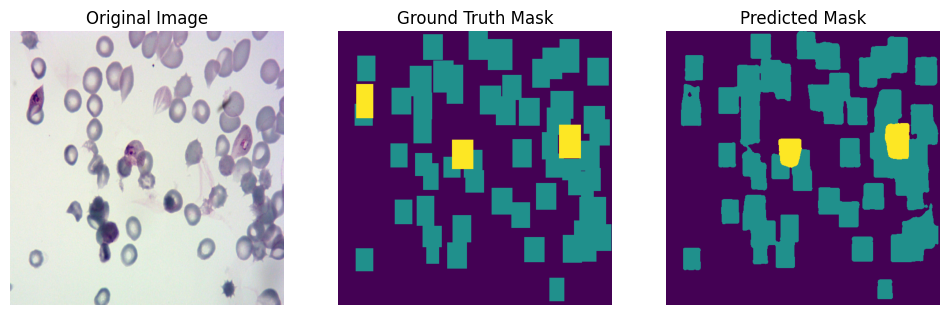

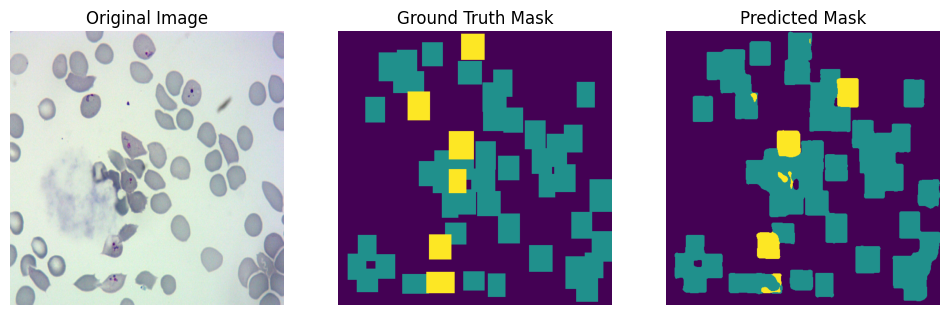

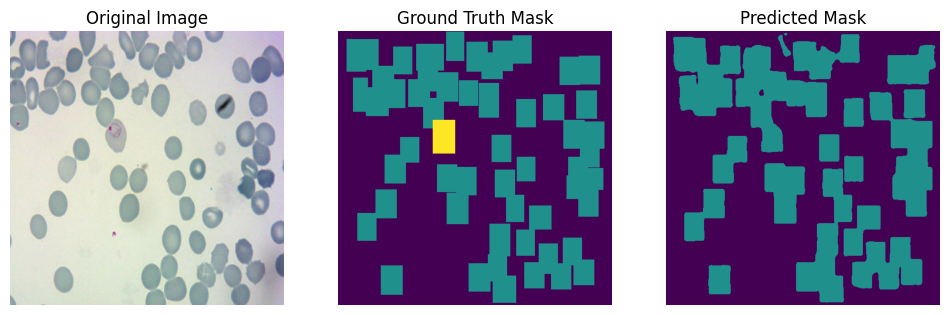

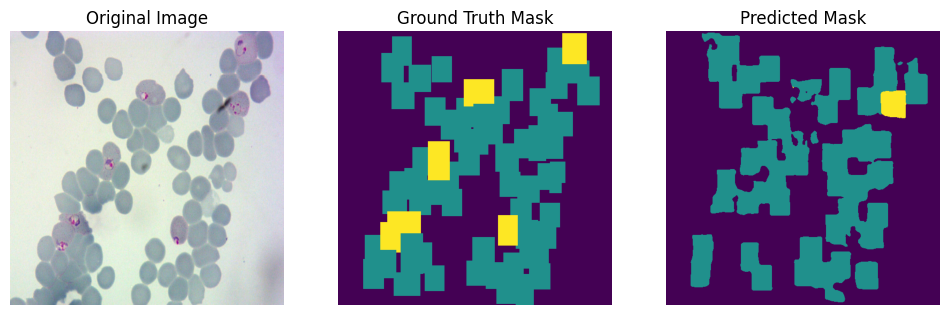

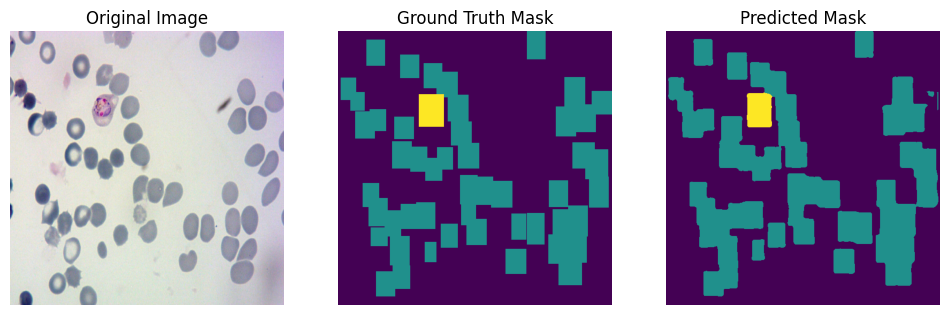

In [ ]:
visualize_predictions(model, test_loader, device, num_samples=5)


# Saving the model

In [ ]:
import torch

model_save_path = "/content/drive/MyDrive/Vision_project/UNET_segmentation/segmentation_model.pth"

torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/Vision_project/UNET_segmentation/segmentation_model.pth


# Load model

In [ ]:
import torch
from segmentation_models_pytorch import Unet

model_save_path = "/content/drive/MyDrive/Vision_project/UNET_segmentation/segmentation_model.pth"

model = Unet(
    encoder_name="resnet50",
    encoder_weights=None,
    in_channels=3,
    classes=3
)


model.load_state_dict(torch.load(model_save_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

print("Model successfully loaded and ready for evaluation.")


<ipython-input-9-93a42067e60e>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_location=torch.device('cuda' if torch.

Model successfully loaded and ready for evaluation.


In [ ]:
import torch
import numpy as np
import time
# This evalautions emtrics are based on a pixwl wise comparison.

def evaluate_segmentation_with_timing(model, dataloader, device):
    model.eval()

    class_names = {1: 'uninfected', 2: 'infected'}
    iou_scores = {class_id: [] for class_id in class_names.keys()}
    correct_pixels = {class_id: 0 for class_id in class_names.keys()}
    total_pixels = {class_id: 0 for class_id in class_names.keys()}
    dice_scores = {class_id: [] for class_id in class_names.keys()}

    total_eval_time = 0
    num_images = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            num_images += len(images)

            # Start timing
            start_time = time.time()
            outputs = model(images)
            end_time = time.time()

            total_eval_time += (end_time - start_time)

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            masks = masks.cpu().numpy()

            for class_id in class_names.keys():
                pred_binary = (preds == class_id).astype(np.uint8)
                gt_binary = (masks == class_id).astype(np.uint8)
                # Get intersection over union based on the pixels resilts for masks
                intersection = np.logical_and(pred_binary, gt_binary).sum()
                union = np.logical_or(pred_binary, gt_binary).sum()

                if union > 0:
                    iou = intersection / union
                    iou_scores[class_id].append(iou)

                dice = 2 * intersection / (np.sum(pred_binary) + np.sum(gt_binary) + 1e-6)
                dice_scores[class_id].append(dice)

                correct_pixels[class_id] += np.logical_and(preds == masks, masks == class_id).sum()
                total_pixels[class_id] += (masks == class_id).sum()

    avg_iou = {class_names[c]: np.mean(iou_scores[c]) if iou_scores[c] else 0.0 for c in class_names.keys()}
    avg_dice = {class_names[c]: np.mean(dice_scores[c]) if dice_scores[c] else 0.0 for c in class_names.keys()}
    accuracy = {class_names[c]: correct_pixels[c] / total_pixels[c] if total_pixels[c] > 0 else 0.0 for c in class_names.keys()}
    avg_eval_time = total_eval_time / num_images if num_images > 0 else 0.0

    print("\nEvaluation Metrics:")
    for category in class_names.values():
        print(f"{category}: IoU = {avg_iou[category]:.4f}, Dice = {avg_dice[category]:.4f}, Accuracy = {accuracy[category]:.4f}")

    print(f"\nAverage Evaluation Time per Image: {avg_eval_time:.4f} seconds")

    return avg_iou, avg_dice, accuracy, avg_eval_time


avg_iou, avg_dice, accuracy, avg_eval_time = evaluate_segmentation_with_timing(model, test_loader, device)



Evaluation Metrics:
uninfected: IoU = 0.8352, Dice = 0.9097, Accuracy = 0.9215
infected: IoU = 0.3772, Dice = 0.5341, Accuracy = 0.4129

Average Evaluation Time per Image: 0.0291 seconds


In [ ]:

total_params = sum(p.numel() for p in model.parameters())
print(f"Total Parameters: {total_params:,}")

Total Parameters: 32,521,395
